# NESTML active dendrite tutorial

In this tutorial, we create a neuron model with an active dendritic compartment, that will fire a dendritic spike if the total synaptic current exceeds a threshold.

**Table of contents**
- [Pulse-shaped dendritic spike](#section_pulse)
- [Dynamically controlling synaptic integration](#section_integration)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import uuid
from pynestml.frontend.pynestml_frontend import to_nest, install_nest

#NEST_SIMULATOR_INSTALL_LOCATION = "/home/beeblebrox/nest-simulator-build"
NEST_SIMULATOR_INSTALL_LOCATION = "/home/charl/julich/nest-simulator-build"

<a id='section_pulse'></a>
## Pulse-shaped dendritic spike

We will use a standard, linear integrate-and-fire neuron with the governing equation:
    
\begin{align}
\frac{dV_m}{dt} &= -\frac{1}{\tau_m} (V_m - E_L) + \frac{1}{C_m} (I_{syn} + I_{dend\_sp})
\end{align}

Here, the term $I_{syn}$ contains all the currents flowing into the soma due to synaptic input, and $I_{dend\_sp}$ contains the contribution of an dendritic spike.

### Implementing the pulse shape

The dendritic spike is modeled here as a rectangular (pulse) function, parameterized by a height (current strength) and width (duration). 

```
parameters:
  I_dend_sp_peak pA = 150 pA   # current clamp value for I_dend during a dendritic spike
  T_dend_sp ms = 10 ms         # time window over which the dendritic current clamp is active
  ...
```

We also define a synaptic current threshold that, when crossed, initiates the dendritic spike:

```
parameters:
  I_th pA = 100 pA         # current-threshold for a dendritic spike
  ...
```

The current is switched on and off as follows. When a dendritic spike fires, the magnitude of the ``I_dend_spike`` current is set to ``I_dend_sp_ampl``, and a timer variable ``t_dend_sp`` is set to the duration of the spike current pulse, ``T_dend_sp``. At each future run of the NESTML ``update`` block, the timer is decremented until it reaches 0, at which point the dendritic spike current ``I_dend_spike`` is set to zero, and the state of the synaptic integration is reset by setting ``I_dend`` and its derivative to zero.
```
update:
  if t_dend_sp > 0 ms:
    # during a dendritic spike pulse
    t_dend_sp -= resolution()
    if t_dend_sp <= 0 ms:
      # end of dendritic spike
      I_dend_spike = 0 pA
      t_dend_sp = 0 ms
    end
  end

  if I_dend > I_th:
    # current-threshold, emit a dendritic spike
    t_dend_sp = T_dend_sp
    I_dend_spike = I_dend_sp_ampl
  end
```

The complete neuron is as follows. Two other somatic currents are also defined, and could correspond to, for example, NDMA and GABA currents on ports ``I_1`` and ``I_3``.

In [2]:
nestml_active_dend_model = '''
neuron iaf_psc_exp_nonlineardendrite:
  initial_values:
    V_m mV = 0 mV         # membrane potential
    t_dend_sp ms = 0 ms   # dendritic spike timer
    I_dend_sp pA = 0 pA   # dendritic spike current magnitude
  end

  equations:
    kernel I_kernel1 = exp(-t / tau_syn1)
    kernel I_kernel2 = (e / tau_syn2) * t * exp(-t / tau_syn2)
    kernel I_kernel3 = exp(-t / tau_syn3)

    recordable inline I_dend pA = convolve(I_kernel2, I_2)

    inline I_syn pA = convolve(I_kernel1, I_1) + I_dend + convolve(I_kernel3, I_3) + I_e

    V_m' = -(V_m - E_L) / tau_m + (I_syn + I_dend_sp) / C_m
  end

  parameters:
    C_m pF = 250 pF          # capacity of the membrane
    tau_m ms = 20 ms         # membrane time constant
    tau_syn1 ms = 10 ms      # time constant of synaptic current, port 1
    tau_syn2 ms = 10 ms      # time constant of synaptic current, port 2
    tau_syn3 ms = 10 ms      # time constant of synaptic current, port 3
    V_th mV = 25 mV          # spike threshold
    V_reset mV = 0 mV        # reset voltage
    I_e    pA = 0 pA         # external current
    E_L    mV = 0 mV         # resting potential

    # dendritic action potential
    I_th pA = 100 pA            # current-threshold for a dendritic spike
    I_dend_sp_peak pA = 150 pA  # current clamp value for I_dend during a dendritic spike
    T_dend_sp ms = 10 ms        # time window over which the dendritic current clamp is active
  end

  input:
    I_1 pA <- spike
    I_2 pA <- spike
    I_3 pA <- spike
  end

  output: spike

  update:
    # solve ODEs
    integrate_odes()

    if t_dend_sp > 0 ms:
      t_dend_sp -= resolution()
      if t_dend_sp <= 0 ms:
        # end of dendritic spike
        t_dend_sp = 0 ms
        I_dend_sp = 0 pA
      end
    end

    if I_dend > I_th:
      # current-threshold, emit a dendritic spike
      t_dend_sp = T_dend_sp
      I_dend_sp = I_dend_sp_peak
    end

    # emit somatic spike
    if V_m > V_th:
      emit_spike()
      V_m = V_reset
    end
  end
end
'''

Save to a temporary file and make the model available to instantiate in NEST:

In [3]:
with open("iaf_psc_exp_nonlineardendrite.nestml", "w") as nestml_model_file:
    print(nestml_active_dend_model, file=nestml_model_file)

to_nest(input_path="iaf_psc_exp_nonlineardendrite.nestml",
        target_path="/tmp/nestml-active-dend-target",
        module_name="nestml_active_dend_module",
        suffix="_nestml",
        logging_level="INFO")
install_nest("/tmp/nestml-active-dend-target", NEST_SIMULATOR_INSTALL_LOCATION)
nest.Install("nestml_active_dend_module")

[1,GLOBAL, INFO]: Start processing '/home/charl/julich/nestml-fork-active_dendrite/nestml/doc/tutorials/active_dendrite/iaf_psc_exp_nonlineardendrite.nestml'!
[2,iaf_psc_exp_nonlineardendrite_nestml, INFO, [2:0;71:0]]: Start building symbol table!
[3,iaf_psc_exp_nonlineardendrite_nestml, INFO]: New type registered '1 / ms'!
[4,iaf_psc_exp_nonlineardendrite_nestml, INFO]: New type registered 'mV / s'!
[5,iaf_psc_exp_nonlineardendrite_nestml, INFO]: New type registered 'mV / ms'!
[6,iaf_psc_exp_nonlineardendrite_nestml, INFO]: New type registered 'pA / pF'!
[7,iaf_psc_exp_nonlineardendrite_nestml, WARNING, [18:11;18:26]]: Non-matching unit types at mV / ms +/- pA / pF! Implicitly replaced by mV / ms +/- 1.0 * pA / pF.
[8,iaf_psc_exp_nonlineardendrite_nestml, INFO, [4:4;4:15]]: Ode of 'V_m' updated!
[9,iaf_psc_exp_nonlineardendrite_nestml, WARNING, [5:4;5:4]]: Variable 't_dend_sp' not provided with an ODE!
[10,iaf_psc_exp_nonlineardendrite_nestml, WARNING, [6:4;6:4]]: Variable 'I_dend_sp'

INFO:ode-toolbox: analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_m' = -(V_m - E_L) / tau_m + ((I_kernel1__X__I_1 + (I_kernel2__X__I_2) + I_kernel3__X__I_3 + I_e) + I_dend_sp) / C_m",
            "initial_values": {
                "V_m": "0"
            }
        },
        {
            "expression": "I_kernel3__X__I_3 = exp(-t / tau_syn3)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel1__X__I_1 = exp(-t / tau_syn1)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel2__X__I_2 = (e / tau_syn2) * t * exp(-t / tau_syn2)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "C_m": "250",
        "E_L": "0",
        "I_dend_sp_peak": "150",
        "I_e": "0",
        "I_th": "100",
        "T_dend_sp": "10",
        "V_reset": "0",
        "V_th": "25",
        "tau_m": "20",
        

[11,GLOBAL, INFO]: Analysing/transforming neuron 'iaf_psc_exp_nonlineardendrite_nestml'
[12,iaf_psc_exp_nonlineardendrite_nestml, INFO, [2:0;71:0]]: Starts processing of the neuron 'iaf_psc_exp_nonlineardendrite_nestml'
[13,iaf_psc_exp_nonlineardendrite_nestml, INFO, [2:0;71:0]]: The neuron 'iaf_psc_exp_nonlineardendrite_nestml' will be analysed!


INFO:
Processing shape I_kernel3__X__I_3 with defining expression = "exp(-t/tau_syn3)"
INFO:
Processing shape I_kernel1__X__I_1 with defining expression = "exp(-t/tau_syn1)"
INFO:
Processing shape I_kernel2__X__I_2 with defining expression = "e*t*exp(-t/tau_syn2)/tau_syn2"
INFO:
Processing shape V_m with defining expression = "-(V_m - E_L) / tau_m + ((I_kernel1__X__I_1 + (I_kernel2__X__I_2) + I_kernel3__X__I_3 + I_e) + I_dend_sp) / C_m"
INFO:
Processing shape I_kernel3__X__I_3 with defining expression = "exp(-t/tau_syn3)"
INFO:
Processing shape I_kernel1__X__I_1 with defining expression = "exp(-t/tau_syn1)"
INFO:
Processing shape I_kernel2__X__I_2 with defining expression = "e*t*exp(-t/tau_syn2)/tau_syn2"
INFO:Shape V_m: reconstituting expression -V_m/tau_m + (C_m*E_L + tau_m*(I_dend_sp + I_e + I_kernel1__X__I_1 + I_kernel2__X__I_2 + I_kernel3__X__I_3))/(C_m*tau_m)
INFO:Shape I_kernel3__X__I_3: reconstituting expression -I_kernel3__X__I_3/tau_syn3
INFO:Shape I_kernel1__X__I_1: reconsti

[14,iaf_psc_exp_nonlineardendrite_nestml, INFO, [2:0;71:0]]: Start building symbol table!
[15,iaf_psc_exp_nonlineardendrite_nestml, INFO, [2:0;71:0]]: Successfully generated code for the neuron: 'iaf_psc_exp_nonlineardendrite_nestml' in: '/tmp/nestml-active-dend-target' !
[16,GLOBAL, INFO]: Successfully generated NEST module code in '/tmp/nestml-active-dend-target' !


### Running the simulation in NEST

Let's define a function that will instantiate the active dendrite model, run a simulation, and plot and return the results.

In [11]:
def evaluate_neuron(neuron_name, neuron_parms=None, I_e=0.,
                    mu=0., sigma=0., t_sim=100., plot=True):
    """
    Run a simulation in NEST for the specified neuron. Inject a stepwise
    current and plot the membrane potential dynamics and spikes generated.
    """
    dt = .1   # [ms]

    MAX_SSE = 1E-12

    I_dend_alias_name = 'I_dend'

    nest.ResetKernel()
    try:
        nest.Install("nestml_active_dend_module")
    except :
        pass
    neuron = nest.Create(neuron_name)
    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)

    sg = nest.Create("spike_generator", params={"spike_times": [10., 20., 30., 40., 50.]})
    
    multimeter = nest.Create("multimeter")
    record_from_vars = ["V_m", I_dend_alias_name]
    if "dend_curr_enabled" in neuron.get().keys():
        record_from_vars += ["dend_curr_enabled"]
    multimeter.set({"record_from": record_from_vars,
                    "interval": dt})
    sr_pre = nest.Create("spike_recorder")
    sr = nest.Create("spike_recorder")

    nest.Connect(sg, neuron, syn_spec={"receptor_type": 2, "weight": 50., "delay": 1.})
    nest.Connect(multimeter, neuron)
    nest.Connect(sg, sr_pre)
    nest.Connect(neuron, sr)
    
    nest.Simulate(t_sim)

    mm = nest.GetStatus(multimeter)[0]
    Voltages = mm["events"]["V_m"]
    tv = mm["events"]["times"]
    dSD = nest.GetStatus(sr, keys='events')[0]
    spikes = dSD['senders']
    ts = dSD["times"]
    
    _idx = [np.argmin((tv - spike_time)**2) - 1 for spike_time in ts]
    V_m_at_spike_times = Voltages[_idx]
    timevec = mm.get("events")["times"]
    I_dend_alias_ts = mm.get("events")[I_dend_alias_name]
    if "dend_curr_enabled" in mm.get("events").keys():
        dend_curr_enabled = mm.get("events")["dend_curr_enabled"]

    ts_sp = nest.GetStatus(sr, keys='events')[0]['times']
    ts_pre_sp = nest.GetStatus(sr_pre, keys='events')[0]['times']
    
    if plot:
        n_subplots = 2
        if "dend_curr_enabled" in mm.get("events").keys():
            n_subplots += 1
        fig, ax = plt.subplots(n_subplots, 1, dpi=100)
        ax[0].scatter(ts_pre_sp, np.zeros_like(ts_pre_sp), marker="v", c="orange", alpha=.8, zorder=99)
        ax[0].plot(timevec, I_dend_alias_ts, label="I_dend")
        if "dend_curr_enabled" in mm.get("events").keys():
            ax[1].plot(timevec, dend_curr_enabled, label="dend_curr_enabled")
            ax[1].set_ylim([-.05, 1.05])
            ax[1].set_yticks([0, 1])
        ax[-1].plot(timevec, mm.get("events")["V_m"], label="V_m")
        ax[-1].scatter(ts_sp, np.zeros_like(ts_sp), marker="v", c="orange", alpha=.8, zorder=99)
        for _ax in ax:
            _ax.legend()
            _ax.grid()
        fig.show()

    return ts

/home/charl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


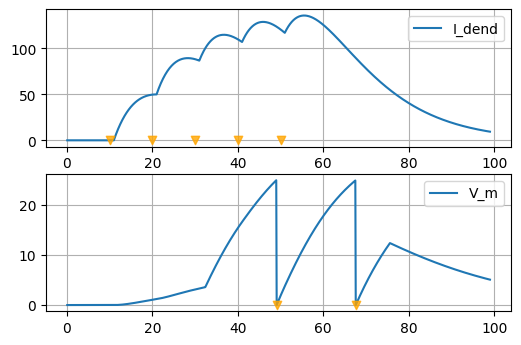

In [12]:
_ = evaluate_neuron("iaf_psc_exp_nonlineardendrite_nestml", neuron_parms={"I_th": 100., "I_dend_sp_peak": 400.})

The presynaptic spikes by themselves are not sufficient by themselves to trigger a postsynaptic spike:

/home/charl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


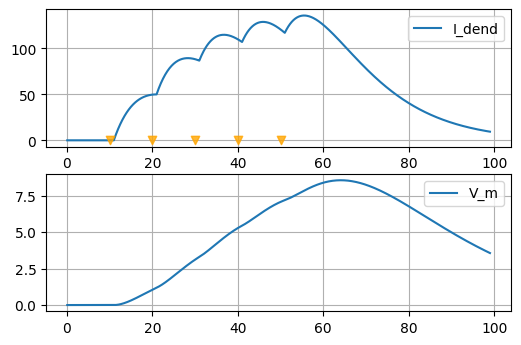

In [13]:
_ = evaluate_neuron("iaf_psc_exp_nonlineardendrite_nestml", neuron_parms={"I_th": 9999.})

<a id='section_integration'></a>
## Dynamically controlling synaptic integration

We now add the additional requirement for the dendritic spike to disable synaptic integration. When a dendritic spike happens, we want to ignore synaptic currents for the duration of the spike, and to reset the synaptic currents such that any presynaptic activity before the dendritic spike is ignored.

To do this, we add a state variable ``dend_curr_enabled``, that will have the value 1 if synaptic current integration is enabled, and 0 in case it is disabled. This variables multiplies the ``I_syn`` term in the differential equation for $V_m$. The new governing equation is then:

\begin{align}
\frac{dV_m}{dt} &= -\frac{1}{\tau_m} (V_m - E_L) + \frac{1}{C_m} (\mathtt{dend\_curr\_enabled} \cdot I_{syn} + I_{dend\_sp})
\end{align}

We can then temporarily disable the synaptic current from contributing to the update of ``V_m`` by setting ``dend_curr_enabled`` to zero, for instance:

```
update:
  if I_dend > I_th:
    # current-threshold, emit a dendritic spike
    ...
    # temporarily pause synaptic integration
    dend_curr_enabled = 0.
    ...
```

In order to ignore presynaptic input that arrives during and before a dendritic spike, we use the inline aliasing feature of NESTML. Usually, synaptic integration is expressed as a convolution, for example:

```nestml
equations:
  kernel syn_kernel = exp(-t / tau_syn)

  V_m' = -(V_m - E_L) / tau_m + convolve(syn_kernel, in_spikes) / C_m
  ...
```

We will define an inline expression that aliases this convolution (see https://nestml.readthedocs.io/en/latest/nestml_language.html#%28Re%29setting-synaptic-integration-state for a more detailed explanation):

```
equations:
  inline I_syn pA = convolve(syn_kernel, in_spikes)
  ...
```

Now, we can not only use the variable ``I_syn`` in expressions, but we can also assign to it. To reset the state of synaptic integration (thereby "forgetting" any past spike events):

```
update:
  ...
    if t_dend_sp <= 0 ms:
      # end of dendritic spike
      ...
      # reset and re-enable synaptic integration
      I_dend = 0 pA
      I_dend' = 0 pA/ms
      dend_curr_enabled = 1.
    end
  end

```

Putting it all together in a new model, we have:

In [14]:
nestml_active_dend_reset_model = '''
neuron iaf_psc_exp_nonlineardendrite_resetting:
  initial_values:
    V_m mV = 0 mV         # membrane potential
    t_dend_sp ms = 0 ms   # dendritic spike timer
    dend_curr_enabled real = 1.   # set to 1 to allow synaptic dendritic currents to contribute to V_m integration, 0 otherwise
    I_dend_sp pA = 0 pA
  end

  equations:
    kernel I_kernel1 = exp(-t / tau_syn1)
    kernel I_kernel2 = (e / tau_syn2) * t * exp(-t / tau_syn2)
    kernel I_kernel3 = exp(-t / tau_syn3)

    recordable inline I_dend pA = convolve(I_kernel2, I_2)

    inline I_syn pA = convolve(I_kernel1, I_1) + dend_curr_enabled * I_dend + convolve(I_kernel3, I_3) + I_e

    V_m' = -(V_m - E_L) / tau_m + (I_syn + I_dend_sp) / C_m
  end

  parameters:
    C_m pF = 250 pF          # capacity of the membrane
    tau_m ms = 20 ms         # membrane time constant
    tau_syn1 ms = 10 ms      # time constant of synaptic current, port 1
    tau_syn2 ms = 10 ms      # time constant of synaptic current, port 2
    tau_syn3 ms = 10 ms      # time constant of synaptic current, port 3
    V_th mV = 25 mV          # spike threshold
    V_reset mV = 0 mV        # reset voltage
    I_e    pA = 0 pA         # external current
    E_L    mV = 0 mV         # resting potential

    # dendritic action potential
    I_th pA = 100 pA             # current-threshold for a dendritic spike
    I_dend_sp_peak pA = 150 pA   # current clamp value for I_dend during a dendritic spike
    T_dend_sp ms = 10 ms         # time window over which the dendritic current clamp is active
  end

  input:
    I_1 pA <- spike
    I_2 pA <- spike
    I_3 pA <- spike
  end

  output: spike

  update:
    # solve ODEs
    integrate_odes()

    if t_dend_sp > 0 ms:
      t_dend_sp -= resolution()
      if t_dend_sp <= 0 ms:
        I_dend_sp = 0 pA
        t_dend_sp = 0 ms
        # reset and re-enable synaptic integration
        I_dend = 0 pA
        I_dend' = 0 pA/ms
        dend_curr_enabled = 1.
      end
    end

    if I_dend > I_th:
      # current-threshold, emit a dendritic spike
      t_dend_sp = T_dend_sp
      I_dend_sp = I_dend_sp_peak
      # temporarily pause synaptic integration
      dend_curr_enabled = 0.
    end

    # emit somatic spike
    if V_m > V_th:
      emit_spike()
      V_m = V_reset
    end
  end
end
'''

Save to a temporary file and make the model available to instantiate in NEST:

In [15]:
with open("iaf_psc_exp_nonlineardendrite.nestml", "w") as nestml_model_file:
    print(nestml_active_dend_reset_model, file=nestml_model_file)

to_nest(input_path="iaf_psc_exp_nonlineardendrite.nestml",
        target_path="/tmp/nestml-active-dend-target",
        module_name="nestml_active_dend_reset_module",
        suffix="_nestml",
        logging_level="INFO")
install_nest("/tmp/nestml-active-dend-target", NEST_SIMULATOR_INSTALL_LOCATION)
nest.Install("nestml_active_dend_reset_module")

[1,GLOBAL, INFO]: Start processing '/home/charl/julich/nestml-fork-active_dendrite/nestml/doc/tutorials/active_dendrite/iaf_psc_exp_nonlineardendrite.nestml'!
[2,iaf_psc_exp_nonlineardendrite_resetting_nestml, INFO, [2:0;77:0]]: Start building symbol table!
[3,iaf_psc_exp_nonlineardendrite_resetting_nestml, INFO]: New type registered '1 / ms'!
[4,iaf_psc_exp_nonlineardendrite_resetting_nestml, INFO]: New type registered 'mV / s'!
[5,iaf_psc_exp_nonlineardendrite_resetting_nestml, INFO]: New type registered 'mV / ms'!
[6,iaf_psc_exp_nonlineardendrite_resetting_nestml, INFO]: New type registered 'pA / pF'!
[7,iaf_psc_exp_nonlineardendrite_resetting_nestml, WARNING, [19:11;19:26]]: Non-matching unit types at mV / ms +/- pA / pF! Implicitly replaced by mV / ms +/- 1.0 * pA / pF.
[8,iaf_psc_exp_nonlineardendrite_resetting_nestml, INFO]: New type registered 'pA / ms'!
[9,iaf_psc_exp_nonlineardendrite_resetting_nestml, INFO, [4:4;4:15]]: Ode of 'V_m' updated!
[10,iaf_psc_exp_nonlineardendrite

INFO:ode-toolbox: analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_m' = -(V_m - E_L) / tau_m + ((I_kernel1__X__I_1 + dend_curr_enabled * (I_kernel2__X__I_2) + I_kernel3__X__I_3 + I_e) + I_dend_sp) / C_m",
            "initial_values": {
                "V_m": "0"
            }
        },
        {
            "expression": "I_kernel2__X__I_2 = (e / tau_syn2) * t * exp(-t / tau_syn2)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel1__X__I_1 = exp(-t / tau_syn1)",
            "initial_values": {}
        },
        {
            "expression": "I_kernel3__X__I_3 = exp(-t / tau_syn3)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "C_m": "250",
        "E_L": "0",
        "I_dend_sp_peak": "150",
        "I_e": "0",
        "I_th": "100",
        "T_dend_sp": "10",
        "V_reset": "0",
        "V_th": "25",
        "ta

[15,iaf_psc_exp_nonlineardendrite_resetting_nestml, INFO, [2:0;77:0]]: The neuron 'iaf_psc_exp_nonlineardendrite_resetting_nestml' will be analysed!


INFO:
Processing shape I_kernel1__X__I_1 with defining expression = "exp(-t/tau_syn1)"
INFO:
Processing shape I_kernel3__X__I_3 with defining expression = "exp(-t/tau_syn3)"
INFO:
Processing shape V_m with defining expression = "-(V_m - E_L) / tau_m + ((I_kernel1__X__I_1 + dend_curr_enabled * (I_kernel2__X__I_2) + I_kernel3__X__I_3 + I_e) + I_dend_sp) / C_m"
INFO:
Processing shape I_kernel2__X__I_2 with defining expression = "e*t*exp(-t/tau_syn2)/tau_syn2"
INFO:
Processing shape I_kernel1__X__I_1 with defining expression = "exp(-t/tau_syn1)"
INFO:
Processing shape I_kernel3__X__I_3 with defining expression = "exp(-t/tau_syn3)"
INFO:Shape V_m: reconstituting expression -V_m/tau_m + (C_m*E_L + tau_m*(I_dend_sp + I_e + I_kernel1__X__I_1 + I_kernel2__X__I_2*dend_curr_enabled + I_kernel3__X__I_3))/(C_m*tau_m)
INFO:Shape I_kernel2__X__I_2: reconstituting expression -I_kernel2__X__I_2/tau_syn2**2 - 2*I_kernel2__X__I_2__d/tau_syn2
INFO:Shape I_kernel1__X__I_1: reconstituting expression -I_kern

[16,iaf_psc_exp_nonlineardendrite_resetting_nestml, INFO, [2:0;77:0]]: Start building symbol table!
[17,iaf_psc_exp_nonlineardendrite_resetting_nestml, INFO, [57:17;57:19]]: Implicit casting from (compatible) type 'pA' to 'real'.
[18,iaf_psc_exp_nonlineardendrite_resetting_nestml, INFO, [58:18;58:23]]: Implicit casting from (compatible) type 'pA / ms' to 'real'.
[19,iaf_psc_exp_nonlineardendrite_resetting_nestml, INFO, [2:0;77:0]]: Successfully generated code for the neuron: 'iaf_psc_exp_nonlineardendrite_resetting_nestml' in: '/tmp/nestml-active-dend-target' !
[20,GLOBAL, INFO]: Successfully generated NEST module code in '/tmp/nestml-active-dend-target' !


If we run the simulation with the same parameters as last time, we now observe only one instead of two spikes, because the synaptic current (shown as ``I_dend`` in the top subplot below) does not contribute to ``V_m`` during the dendritic spike interval. This is because the multiplicative term 

/home/charl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


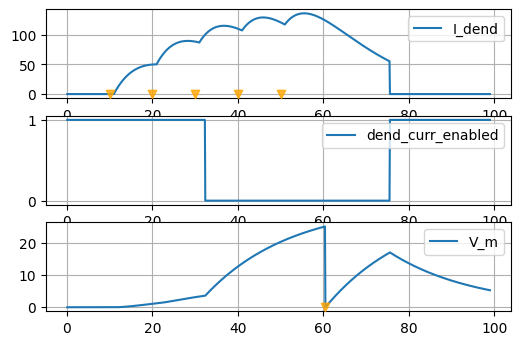

In [16]:
_ = evaluate_neuron("iaf_psc_exp_nonlineardendrite_resetting_nestml",
                    neuron_parms={"I_th": 100., "I_dend_sp_peak": 400.})

## Acknowledgements

We extend our gratitude to Younes Bouhadjar for his contributions.

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270 and No. 785907 (Human Brain Project SGA1 and SGA2).


## Copyright

This file is part of NEST.

Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with NEST.  If not, see <http://www.gnu.org/licenses/>.
